In [23]:
import pandas as pd
import numpy as np

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score

import os
import joblib
import pickle

import time
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import seaborn as sns

import stability as st

import statistics
import scipy as scp
import math
import random

import lime
from lime import lime_tabular

from collections import Counter

import shap

In [24]:
#PATH = "C:/Users/velmurug/Documents/Stability Experiments/Breast Cancer/"
PATH = "C:/Users/mythr/Documents/GitHub/Stability-Experiments/Breast Cancer/"
model_filename = os.path.join(PATH, "models/diabetes_xgb.joblib")
dataset_path = 'datasets/'
model = joblib.load(model_filename)

In [25]:
tn_file = os.path.join(PATH, "datasets/dicts/true_pos.pkl")
with open (tn_file, 'rb') as f:
    results = pickle.load(f)
    
f.close()

In [26]:
X_train = pd.read_csv(PATH + "datasets/breast_cancer_Xtrain.csv", index_col=False).values
X_test = pd.read_csv(PATH + "datasets/breast_cancer_Xtest.csv", index_col=False).values
X_validation =pd.read_csv(PATH + "datasets/breast_cancer_Xvalidation.csv",index_col=False).values
y_train = pd.read_csv(PATH + "datasets/breast_cancer_Ytrain.csv",index_col=False).values
y_test =pd.read_csv(PATH + "datasets/breast_cancer_Ytest.csv", index_col=False).values
y_validation = pd.read_csv(PATH + "datasets/breast_cancer_Yvalidation.csv", index_col=False).values

original_data = pd.read_csv(PATH + "datasets/breast_cancer.csv")
original_data = original_data.dropna(axis = 'columns')
original_data = original_data.drop(['id'], axis = 1)
feature_names = original_data.drop(["diagnosis"], axis = 1).columns

In [27]:
feature_names

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [28]:
MAX_FEAT = 10

start_time = time.time()

# LIME has one explainer for all the models
explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names= feature_names, 
                                                  class_names=["Benign", "Malignant"], verbose=False, mode='classification')

elapsed = time.time() - start_time

print ("Time taken to create explainer:", round(elapsed, 2), "seconds")

Time taken to create explainer: 0.03 seconds


In [29]:
stability_scores = []
probas = []
changes = []
feat_list = list(feature_names)

for instance in results:
    print ("Running instance", results.index(instance))
    
    feat_pres = []

    print("INDEX = %d" %instance['index'])
    patients_feat = np.array(instance['scaled_vector'])
    prediction = instance['predictions']
    p1 = instance['prediction_probability'][1]
    probas.append(p1)
    
    start_time = time.time()
    # explain instance
    explanations = []
    
    for iteration in range(3):
        print("Explaining instances - Run", iteration)
        lime_exp = explainer.explain_instance(patients_feat, model.predict_proba, num_features = MAX_FEAT)
        explanation = lime_exp.as_list()
        explanations.extend(explanation)
    
    features = []
    for explanation in explanations:
        features.append(explanation[0])

    print("Removing duplicates")
    counter = Counter(features)
    check_dup = []
    for feat in feat_list:
        for feature in counter:
            if feat in feature:
                check_dup.append(feat)

    dup_counter = Counter(check_dup)
    duplicated = [feat for feat in dup_counter if dup_counter[feat] > 1]

    for each in duplicated:
        dpls = []
        vals = []
        for feat in counter.keys():
            if each in feat:
                dpls.append(feat)
                vals.append(counter[feat])
        keepval = vals.index(max(vals))
        for i in range(len(dpls)):
            if i != keepval:
                del counter[dpls[i]]

    rel_feat = counter.most_common(MAX_FEAT)
    
    intervals = []

    for item in rel_feat:
        print("Creating distribution for feature", rel_feat.index(item))
        feat = item[0]
        #print(item)
        #print(feat)
        for n in range(len(feat_list)):
            if feat_list[n] in feat:
                if ("<" or "<=") in feat and (">" or ">=") in feat:
                    two_sided = True
                    parts = feat.split(' ')
                    l_bound = float(parts[0])
                    u_bound = float(parts[-1])
                    interval = u_bound - l_bound
                    new_min = u_bound
                    new_max = u_bound + interval
                else:
                    two_sided = False
                    parts = feat.split(' ')
                    if parts[-2] == "<=" or parts[-2] == "<":
                        u_bound = float(parts[-1])
                        if u_bound != 0:
                            interval = math.ceil(u_bound*1.1)
                        else:
                            interval = 5
                        new_min = u_bound
                        new_max = u_bound + interval
                    elif parts[-2] == ">=" or parts[-2] == ">":
                        l_bound = float(parts[-1])
                        if l_bound != 0:
                            interval = math.ceil(l_bound*1.1)
                        else:
                            interval = 5
                        new_max = l_bound
                        new_min = l_bound - interval
                    else:
                        bound = float(parts[-1])
                        interval = math.ceil((bound*1.1)/2)
                        new_min = bound
                        new_max = bound+interval
                feature_name = feat_list[n]
                index = n
                int_min = new_min
                int_max = new_max
                intervals.append((feature_name, index, int_min, int_max))
        
    #print("List of changes:", intervals)

    diffs = []
    for iteration in range(3):
        print("Pertubing - Run", iteration+1)
        alt_x = np.copy(patients_feat)
        #print("original:", alt_x)
        for each in intervals:
            new_val = random.uniform(each[2], each[3])
         #   print(each[1])
         #   print(new_val)
            alt_x[each[1]] = new_val
        #print("altered:", alt_x)
        p2 = model.predict_proba(alt_x.reshape(-1, len(alt_x)))[0][0]
        diff = p1-p2
        diffs.append(diff)

    changes.append(np.mean(diffs))#np.std(diffs))
    #each['lime_fid_change'] = diff#s
    #print("RMSE for instance:", np.std(diffs))
 


Running instance 0
INDEX = 37
Explaining instances - Run 0
Explaining instances - Run 1
Explaining instances - Run 2
Removing duplicates
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Running instance 1
INDEX = 0
Explaining instances - Run 0
Explaining instances - Run 1
Explaining instances - Run 2
Removing duplicates
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for

Explaining instances - Run 1
Explaining instances - Run 2
Removing duplicates
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Running instance 16
INDEX = 10
Explaining instances - Run 0
Explaining instances - Run 1
Explaining instances - Run 2
Removing duplicates
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing 

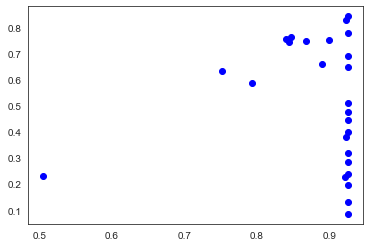

In [30]:
plt.plot(probas, changes, 'bo')
plt.show()

In [31]:
#RMSE
sq_changes = []
abs_changes = []
for each in changes:
    sq_changes.append(each**2)
    abs_changes.append(abs(each))
MSE = sum(sq_changes)/len(sq_changes)
RMSE = math.sqrt(MSE)
MAE = sum(abs_changes)/len(abs_changes)

print('MSE:', MSE)
print('RMSE:', RMSE)
print('MAE:', MAE)

percent_change = []

for i in range(len(probas)):
  #  change = probas[i] - changes[i]
    rel_change = changes[i]/probas[i]
    percent_change.append(abs(rel_change))
MAPE = sum(percent_change)/len(percent_change)
print('MAPE:', MAPE)

MSE: 0.3213968502507669
RMSE: 0.5669187333743408
MAE: 0.5152218625522577
MAPE: 0.5884210192240201


# SHAP

In [32]:
X_train_frame = pd.DataFrame(data = X_train, columns = feature_names)
X_test_frame = pd.DataFrame(data = X_test, columns = feature_names)

data_sample = shap.kmeans(X_train_frame, 100)
shap_explainer = shap.KernelExplainer(model.predict_proba, data_sample)#, link = 'identity')

shap.initjs()

In [33]:
shap_values = shap_explainer.shap_values(X_test_frame)
shap_val_feat = np.transpose(shap_values[0])
feats = np.transpose(X_test_frame.values)

0
-0.003319032523055737 19
-0.002788402854279809 19
-0.0023968110535869946 19
0.0 19
0.002667397893286655 20
-0.0039993540872016176 19
0.0029715089412748474 20
-0.0029347422908083953 19
0.001260030573847798 20
-0.0032077370005912376 19
-0.0026852361802800206 19
0.0031055123160986797 20
0.0 19
-0.0029062512677754393 19
0.002338293977575734 20
0.0016970766637704193 20
-0.003447839971828348 19
0.0023351994757709327 20
0.0 19
-0.002059466293174883 19
0.002790651177114689 20
0.0 19
0.003064867611571015 20
0.0 19
0.0 19
0.0 19
0.002988670665628995 20
0.0 19
0.0034065068004439647 20
0.002515005150199867 20
-0.002547161932633296 19
0.0 19
0.0022935298499710544 20
-0.0028536348693938285 19
0.0020642680681792203 20
0.0 19
0.0 19
0.0010923352264914643 20
-0.0030485622029235993 19
-0.0022496355679156727 19
0.0 19
0.0 19
0.001528613012104385 20
0.0016997039611894582 20
0.0023952754922174357 20
-0.002599457561242191 19
0.0035055651187405334 20
0.0018254660217085494 20
0.0021083294315658585 20
0.0 19

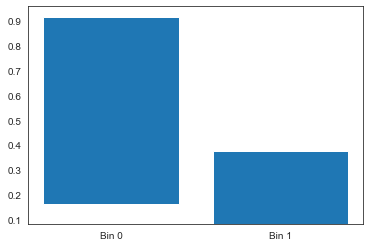

1
-0.002881784612927707 19
-0.0024596106271296825 19
-0.005254834096403038 19
0.003053092953373443 20
0.0 19
-0.0021551330175983985 19
0.0008283411323120327 20
-0.0031661206651874274 19
0.0 19
-0.003726046758811441 19
-0.0033415998921045575 19
0.0 19
-0.004794258983080502 19
0.019776564965097 20
0.0 19
0.006802583185646582 20
-0.002702233421382566 19
0.0 19
-0.0019189542448667107 19
-0.0043103468915256515 19
0.0 19
0.0 19
0.0 19
0.0 19
0.017873564983037347 20
0.0 19
0.0 19
-0.0028445235179840045 19
0.0 19
0.0 19
-0.0036289721292027954 19
0.006093527440438923 20
0.005347807358597578 20
-0.0031803595365985093 19
0.0 19
-0.004083627943431395 19
0.0 19
0.0029607136894796715 20
-0.0018825496458065305 19
0.014184281738384624 20
0.0 19
-0.004517691566187726 19
0.007796516583627733 20
0.0 19
0.0057731608468591655 20
-0.0033801370762802097 19
0.0 19
0.007088509163181267 20
0.0 19
0.0 19
0.00801946662384559 20
-0.006367970031264013 19
-0.00378662361987106 19
0.0 19
0.0 19
-0.004710884809368432 1

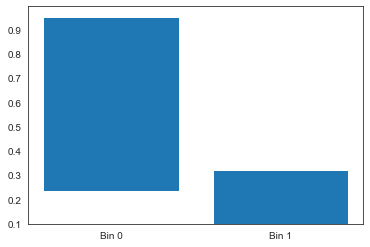

2
-0.0021421869345554234 19
-0.0025607911812658424 19
-0.0016444702792984822 19
0.0 19
0.0 19
-0.003997488882418021 19
0.0 19
-0.002461875720078832 19
0.0 19
-0.0019343820850749038 19
-0.0020006891240488822 19
0.0 19
0.0 19
-0.0021427611828236937 19
0.0006730733478886308 20
0.0 19
-0.002320874187572264 19
0.0029602603444050524 20
-0.002725969804680678 19
-0.0017681756702136037 19
0.0023316938512050467 20
0.0029794673475337097 20
0.0017690389121672034 20
0.0 19
0.0 19
0.0025259684912712077 20
0.0026131515595297916 20
0.0 19
0.0026970002713204155 20
0.0031964553839020915 20
-0.0030435421689347375 19
0.003310459539053706 20
0.004699591291526362 20
-0.002804644889128044 19
0.0024563961661573097 20
0.0 19
0.0028573913952027463 20
0.0035867010221808104 20
-0.003113480431678972 19
-0.0019252049222859627 19
0.004031997379459513 20
0.0 19
0.00301775904938012 20
0.0029841936436986183 20
0.002667665958026477 20
-0.0027444453582542994 19
0.0014725763471651887 20
0.0028019383239337725 20
0.00205996

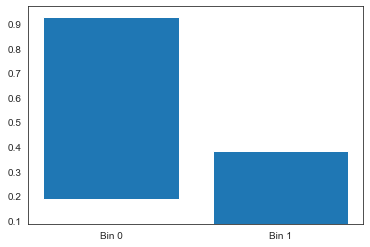

3
0.0 19
-0.0035443449488115064 19
-0.002147017944592211 19
0.0027699944820793743 20
0.0 19
-0.0029195903363290476 19
0.0017601331784423135 20
-0.0031270022554675814 19
0.0029746444490443835 20
-0.002386660773947724 19
0.0 19
0.002614569519488963 20
-0.004846609562383822 19
0.0 19
0.0023662257226651773 20
0.0 19
-0.002767087592883105 19
0.002530847329336644 20
-0.002937005019496175 19
-0.003907389733496913 19
0.0 19
0.004579629283972847 20
0.0014565513824204568 20
0.0029169353334911885 20
-0.0036123235551951214 19
0.0022137193904682717 20
0.0031870987635336245 20
-0.004320917573412519 19
0.0018257715662463314 20
0.0030160914644228876 20
-0.0036139668721767992 19
0.002616135972053485 20
0.0034321047524259463 20
-0.0026050463443375582 19
0.003014826791790992 20
0.0 19
0.002173833611892025 20
0.0017177339857837037 20
-0.0019675805017613235 19
0.0 19
0.0 19
-0.0023236382526254096 19
0.0022263203578426483 20
0.002670208610646513 20
0.002888929492627479 20
-0.0015959206827547423 19
0.0023264

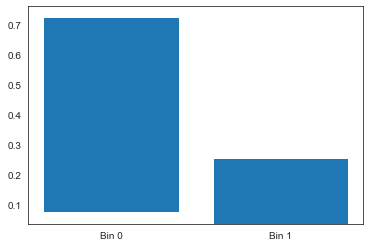

4
-0.0025875025368919946 19
-0.0023351537062322736 19
0.0 19
0.007808763091278786 20
0.0 19
0.0 19
0.0 19
-0.002225106651091935 19
0.005029478141033744 20
-0.0033469163975770044 19
0.0 19
0.0014705592336042572 20
0.0 19
0.0 19
0.0039137163541120845 20
0.0 19
-0.0022888305281505705 19
0.0012730885786563506 20
-0.0022995851956899016 19
-0.0028153096900616625 19
0.0 19
0.0024169736317171675 20
0.0 19
0.0 19
0.008382122780699353 20
0.0 19
0.0 19
-0.0014240897430067845 19
0.0 19
0.0 19
-0.002248858727675246 19
0.0 19
0.0 19
-0.0033233688467381173 19
0.0 19
0.0 19
-0.0022956680576417202 19
0.0 19
-0.0017575633428838222 19
-0.001981392176573789 19
-0.0020720805599845626 19
-0.001422114079009218 19
0.001374706944776205 20
0.0036299144348888313 20
0.006859765359961328 20
-0.002193996758607736 19
0.0 19
0.0 19
0.002180429078611046 20
0.0 19
0.0 19
0.004795312201167759 20
0.0 19
-0.0011468488471697846 19
0.0 19
0.0 19
0.0 19
0.0074312219539024865 20
0.0 19
0.0 19
0.0 19
0.00765859034557706 20
-0.

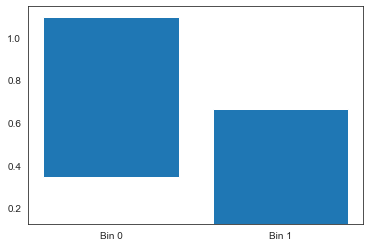

5
0.0 19
0.0 19
-0.0017675364878550481 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0013530362763242987 20
0.0 19
0.0 19
0.0 19
0.0 19
-0.0007305784498973511 19
0.0006837206954831143 20
-0.0019149166912515725 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0015280766344628605 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0014792568173572218 20
0.0 19
0.0 19
0.001665407704577515 20
0.0 19
0.0 19
-0.0006951447142546086 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19


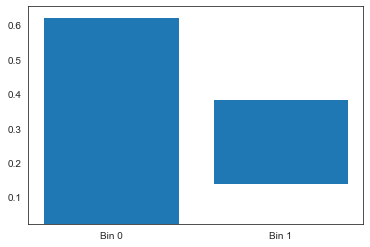

6
-0.019335568450193102 19
-0.013736360276909776 19
-0.012803931510806527 19
0.012757250311108276 20
0.013654376568699625 20
-0.013985124745092836 19
0.01140707844625255 20
-0.013796852720346614 19
0.014187222198095956 20
-0.013857346668266435 19
-0.012508376999145338 19
0.01161208522151369 20
0.010874201111083781 20
-0.016164428045816276 19
0.014764703568886983 20
0.014674438410047091 20
-0.013015241807430633 19
0.012614098638733334 20
-0.01387467627736827 19
-0.017333245193423302 19
0.014104543073740733 20
0.0143419585966508 20
0.01563010288680522 20
0.014779630675270022 20
0.011226085213211416 20
0.012508699554546893 20
0.012420948513120422 20
0.0 19
0.012412171203870892 20
0.011995430618791048 20
-0.01373391505841412 19
0.013558643304624196 20
0.013008887780308676 20
-0.013625357824756185 19
0.009984647456411755 20
0.0071356049372954256 20
-0.012248401322483473 19
0.012444674592325594 20
-0.012861468293951739 19
-0.02231935190928961 19
-0.01178459038478443 19
-0.013798525094927572 

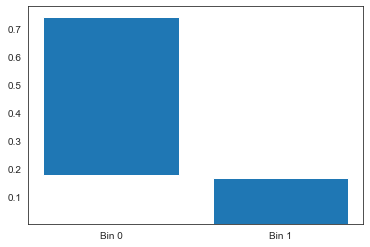

7
-0.0781555313064758 18
-0.04580205477166727 19
-0.054565020411228016 18
0.04042594348852807 20
0.04039342150081607 20
-0.04423676484690006 19
0.043223803904415214 20
-0.04326326848382575 19
0.04531257525867727 20
-0.04547622040561414 19
-0.048724103821323084 19
0.04063808593552365 20
-0.023055502751638562 19
-0.06882987696382831 18
0.04242688209883819 20
0.0512661846303713 21
-0.043729269861732756 19
0.0451462514739111 20
-0.057453374972854104 18
-0.0831993553536603 18
0.04309744700901674 20
0.042657317476272216 20
0.04350632900998813 20
0.04219180993870414 20
0.01847417960879289 20
0.04149899626774248 20
0.0433588956039076 20
-0.045262480727972676 19
0.04571064098371655 20
0.039973413881304265 20
-0.04433796850872229 19
0.04363282335051302 20
0.04236560296767711 20
-0.04642823844304933 19
0.05235004633928722 21
0.029098118162885017 20
-0.06327396922761955 18
0.042812181426066354 20
-0.04567671515340754 19
-0.08617456625035456 18
-0.057925066240812784 18
-0.04801334690079623 19
0.041

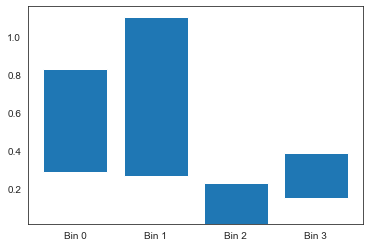

8
0.0 19
0.0 19
-0.0009309521859137693 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0012786676527504481 19
0.0 19
-0.0011416833595684905 19
-0.002096305270796406 19
0.0 19
-0.0013837995459888286 19
0.0 19
0.00120015095747944 20
0.0 19
-0.0011979833525664063 19
0.0015703897449942383 20
-0.001180156332516169 19
0.0 19
0.007616885131331991 20
0.0 19
0.0 19
0.0 19
0.021610896383718506 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0010504046029378988 19
0.0008525757018137126 20
0.0 19
0.0 19
0.0015191330170748474 20
0.0 19
0.0 19
0.008682143744425913 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0007419265920192986 20
0.0 19
0.0 19
0.0 19
0.0 19
-0.0015312389015111894 19
0.0 19
-0.001954982645676673 19
0.000577245444032759 20
0.0 19
0.0007278121668234383 20
0.0 19
0.0 19
0.0 19
0.0 19


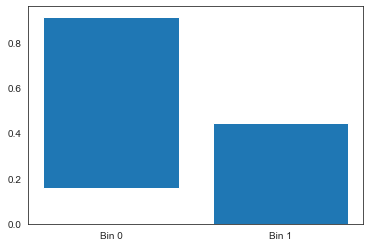

9
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0012656306483720403 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0008787343806946901 19
0.0 19
0.0 19
0.0 19
0.0013796575751206241 20
0.0008296444957253957 20
0.0 19
0.0 19
0.0 19
0.01265530974262378 20
0.0 19
0.0 19
0.0 19
0.007458498884287466 20
0.0 19
0.0006241448455652221 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19


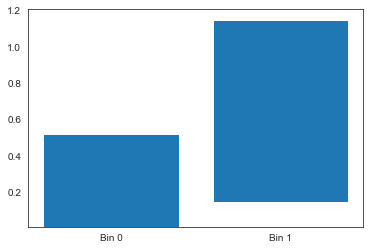

10
0.0 19
0.0 19
0.0 19
0.016791578626287412 20
-0.014394847873762773 19
-0.006353410721305519 19
0.002391540925227642 20
-0.005468240344349118 19
0.0018816413522296238 20
0.0 19
0.0 19
0.010785447098353551 20
-0.00715865354059389 19
0.0 19
0.003511795977108406 20
0.0029501226736935726 20
-0.007271305082217017 19
0.0026354863921493887 20
-0.0010930763547545297 19
0.0 19
0.003570395300638879 20
0.0 19
0.0033298432805521083 20
0.0024153749497885235 20
0.0 19
0.0026040344148738903 20
0.004949910539664648 20
0.0 19
0.004392956622147726 20
0.0031655298614056415 20
-0.005251182578003388 19
0.001102854101888151 20
0.0024649692207520946 20
0.0 19
0.0025115605547307296 20
0.0 19
0.0 19
0.005363076647206894 20
0.0 19
0.0 19
0.0 19
0.0 19
0.014396430595294218 20
0.003851142657554818 20
0.0038653931382142126 20
-0.00625059874639175 19
0.0032906970476566655 20
0.01426746880293786 20
0.003914172803382798 20
0.0 19
0.003239567066282173 20
0.0032423150704658232 20
0.0 19
-0.0053196127760966605 19
-0.0

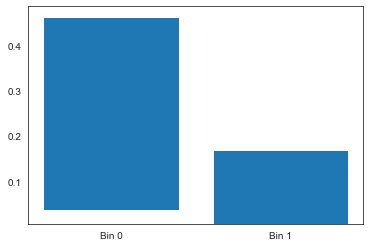

11
0.0 19
0.0 19
-0.0012351756048276652 19
0.0009281921666683957 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0030532086396660996 19
0.0 19
0.0009230749669752181 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0011389401197820503 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.001004992097387386 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0010646608187007134 20
0.01762348536919567 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19


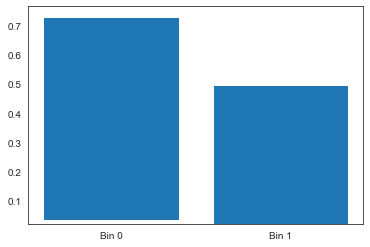

12
0.0 19
0.0 19
0.0 19
0.0046378760067414815 20
0.0 19
-0.0022800875642887686 19
0.0015488038367583723 20
-0.0012007754515379887 19
0.0021831867441180763 20
0.0 19
-0.0016686087053237042 19
0.0010211205154189995 20
-0.0031760867854874197 19
-0.006016368803998251 19
0.0012507718182601657 20
0.003458857880267341 20
-0.002871974960638596 19
0.0019510842951370733 20
0.0 19
0.0 19
0.0 19
0.0030210794056188817 20
0.001396881311024445 20
0.0 19
0.0 19
0.0019651358103266736 20
0.0021584952290746307 20
0.0 19
0.0 19
0.0 19
-0.0014064654455568926 19
0.0017775485440738037 20
0.0019333544819421233 20
0.0 19
0.001997980348875661 20
0.0 19
0.0 19
0.001660385922071489 20
0.0 19
0.0 19
0.0 19
0.0 19
0.005583007269920448 20
0.0 19
0.0 19
-0.0018713452234252193 19
0.0010382862393573666 20
0.006011512561869575 20
0.0017494240630659963 20
0.0 19
0.0 19
0.0 19
0.0 19
-0.002024017218609786 19
-0.009640073258159812 19
0.0 19
0.001102954466009387 20
0.0 19
0.0013473280620193984 20
0.006015419574797898 20
0.0

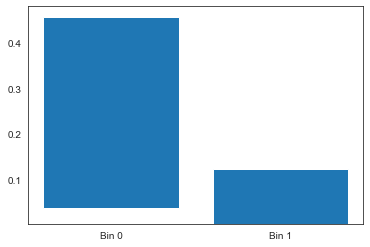

13
-0.006064640230377588 19
-0.04516648810194113 19
-0.011313463525585488 19
0.03660080068868632 20
-0.007259380965645684 19
-0.047823165397863715 19
0.02241594817674497 20
-0.04477636879104291 19
0.011515192911514427 20
-0.04985180055229177 19
-0.050809185636124465 18
0.03302104142021858 20
-0.05622949893581383 18
-0.08358902987373606 18
0.026428052577830097 20
0.02607835501014244 20
-0.04638924530825683 19
0.0276648708335136 20
-0.0047835689060394815 19
-0.004755972679084369 19
0.022189923615809348 20
0.025832053933284083 20
0.025666379642998394 20
0.0344834233128071 20
-0.06444501607994904 18
0.026072994054635645 20
0.035791009132248974 20
-0.005568801330100487 19
0.036019001677644547 20
0.03568993055679842 20
-0.04582132895324931 19
0.02756447020934713 20
0.02249112765598482 20
-0.04739644510244828 19
0.033079742776088994 20
-0.01680551588986917 19
0.007043684726496242 20
0.02592251150221847 20
-0.04858786262007875 19
-0.009161492631178686 19
0.024481187644113684 20
-0.047644802570

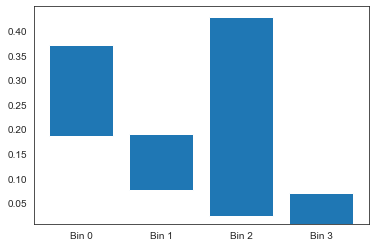

14
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0006096584890585566 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.03425316238261883 19
0.0 19
0.0 19
0.0 19
-0.011272155247628923 19
0.0 19
0.0 19
-0.0009134264492839939 19
0.0 19
0.0005993591383247343 20
0.0 19
0.0013887991596970573 20
0.0 19
0.0 19
0.00036702348294487264 20
-0.0009718650398990447 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.003256966144839113 20
0.0 19
0.0 19
0.0 19
0.0019238029290201408 20
0.0 19
0.0 19
-0.0006342559746465581 19
0.0 19
0.0 19
0.0 19
-0.02394809805912841 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19


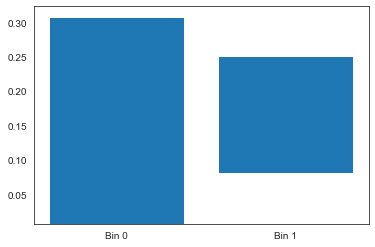

15
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0021033017469469784 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0008466381305975712 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0015973493555161422 20
0.0 19
0.0 19
0.0 19


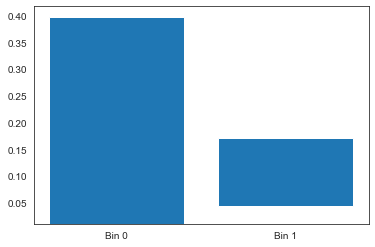

16
0.0 19
0.0 19
-0.0019930373994135886 19
0.00413286277421851 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.001112701355418716 19
-0.0012658018185389697 19
0.0 19
-0.0018976742063720187 19
0.0 19
0.0038262073677646224 20
0.0 19
-0.00164931774278132 19
0.0 19
-0.0012753561272829117 19
-0.002406341142897672 19
0.0038780868319434336 20
0.0 19
0.006111417268271885 20
0.0 19
0.003667712357993489 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0023907158280978558 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0015776149226407465 19
0.0 19
0.0 19
0.0 19
-0.0022993911449328552 19
0.0010395542123943224 20
0.0 19
0.0 19
0.0 19
0.0012118724814366155 20
0.0 19
0.0 19
-0.0013036775377563425 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0027561385910254144 20
0.0 19
0.0 19
0.0 19
0.0 19


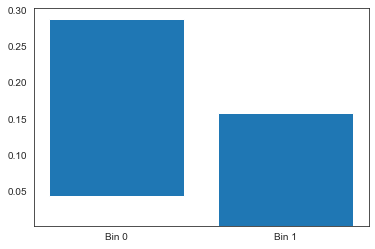

17
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0009532214773507464 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.001499035932482684 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0016749119504083365 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0014544995866653254 19
0.0009741006711696809 20
0.00041248124000184405 20
0.0 19
0.0 19
0.0 19
0.0 19
0.00025883161083184447 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0013051640946408483 20
0.0 19
0.0014278471928092507 20
0.0 19
0.0 19
0.0 19
0.0 19


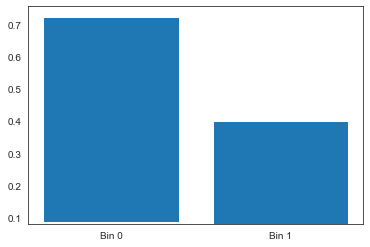

18
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.001253386138133833 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-3.634897779516977e-05 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19


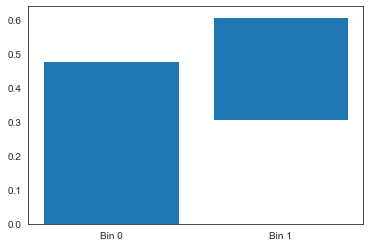

19
-0.001782911707509549 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0006780437462824696 19
0.0008376516921623223 20
-0.0007221967743817337 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.002342011988491973 20
0.0019480228568192204 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0013749657582340369 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0009694506954934512 19
0.0 19
0.0 19
0.0011637178846690688 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19


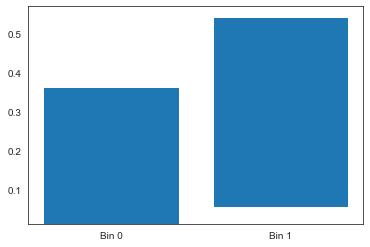

20
-0.03521739284458372 19
-0.08507572923168305 18
-0.08912771233186473 18
0.06186770787403423 21
0.07851325815812177 21
-0.08061903608427123 18
0.08100909956665894 21
-0.0813960791018265 18
0.0758490391728211 21
-0.08610619479425902 18
-0.08508091728960543 18
0.07306853756284623 21
-0.0847446744411538 18
-0.008486992220859371 19
0.07917835424323383 21
0.10132290958237106 22
-0.08277748799012818 18
0.07903598894289154 21
-0.09163859441938504 18
-0.03411406913444559 19
0.07568753078670476 21
0.08223779226986092 21
0.08082348426092534 21
0.07150257093707574 21
-0.0703346755106393 18
0.08253155059730449 21
0.07803671725826283 21
-0.09565684703032082 18
0.07979464535326347 21
0.07978642211469339 21
-0.08142862493816705 18
0.07766394463004261 21
0.07881084489722168 21
-0.08669350886360214 18
0.10721194994167738 22
-0.13070426133797663 17
0.07861466017924654 21
0.07675357496672422 21
-0.08428933945865102 18
-0.00645372550921236 19
0.07427377251111829 21
-0.08464865460479723 18
0.065647390475

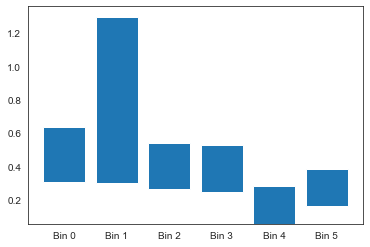

21
-0.02174197251817439 19
-0.01057928120634416 19
-0.022613128372844793 19
0.008481646325993852 20
-0.03790677827397741 19
-0.0036875877256376255 19
0.009004001485941437 20
-0.020309964526609853 19
0.008393735468858854 20
-0.002317853519169688 19
-0.0029064455416233648 19
-0.03898569578385047 19
-0.0038050650900119665 19
0.0443473219809193 20
0.007236079794882305 20
0.022062551210532105 20
-0.007731660432605453 19
0.0051096536161790995 20
-0.001481678997358099 19
0.0 19
-0.04880904523615601 19
0.0071441121978743916 20
0.006745550533936079 20
0.008633454025431309 20
0.02924393052991465 20
0.007747913575191695 20
0.007314201474219545 20
-0.0020135301045206278 19
0.007468867540939728 20
-0.010838868181534317 19
-0.008932123189596075 19
0.02443077981723918 20
0.021116709624912494 20
-0.005891651968039424 19
0.006706441344322467 20
-0.010967659869419666 19
0.0037120154330791463 20
0.009597074052743931 20
-0.003615817972756674 19
0.05346599148164288 21
-0.005470408242776517 19
-0.0023417886

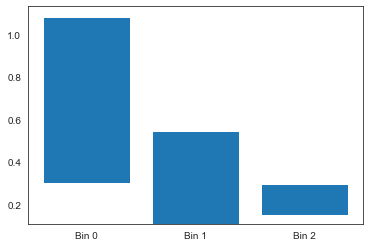

22
-0.12048656633153448 17
-0.10572610211286854 17
-0.10360779096554334 17
0.09768754162723348 21
0.10651467839321144 22
-0.10630891122224861 17
0.10901018900083381 22
-0.10283023690274395 17
0.1042857334920225 22
-0.10694595207752822 17
-0.10438898050315437 17
0.11051388493400285 22
-0.10115555522176223 17
-0.0833540398270615 18
0.10079046971349581 22
0.11076577749185129 22
-0.10445308362901193 17
0.10978494139943767 22
-0.11796081709348533 17
-0.12172293184538902 17
0.09954536163647015 21
0.11123904839409529 22
0.1057621667766053 22
0.11394695994842524 22
-0.05792857901648551 18
0.11389597150124109 22
0.10921884032738857 22
-0.11444612880651467 17
0.11174148185220717 22
0.11192795349716772 22
-0.10589604027629301 17
0.0962209930932236 21
0.09305830802332643 21
-0.10928982383546282 17
0.12495132630647732 22
-0.11101908912053043 17
0.1037112976650947 22
0.08087828906623581 21
-0.11037395384009696 17
-0.09368840437970688 18
0.10362034089760201 22
-0.10859938478220893 17
0.10585831347297

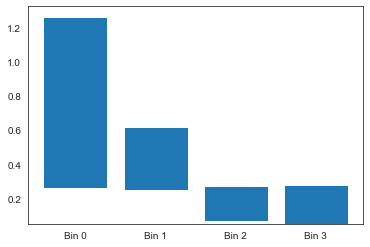

23
-0.0015538784886263701 19
-0.04384525090932134 19
-0.04500562067206493 19
0.04046482279554131 20
0.04064936617756473 20
-0.0455738478888468 19
0.04377652702607801 20
-0.04396971458067961 19
0.04072672445687789 20
-0.04725093563715824 19
-0.04616837511926872 19
0.041486113388813056 20
-0.053940000597053256 18
0.007313556752942249 20
0.041343018732204584 20
0.042918790333910856 20
-0.04473170922496131 19
0.03988233028898583 20
-0.05175692790680861 18
0.0 19
0.0348704013970319 20
0.041698954628483914 20
0.041790568345901835 20
0.03813168158442301 20
-0.04489143457505811 19
0.04337589205805051 20
0.04232920549223182 20
-0.060245884114170783 18
0.04463770415509832 20
0.0409110270094544 20
-0.044364798460297894 19
0.04069234265339297 20
0.03919690335927126 20
-0.04621170708841216 19
0.04881505024765326 20
-0.0662639101504357 18
0.0430188243301571 20
0.043051042733209116 20
-0.048515033633282745 19
0.010503387499242782 20
0.041736820382731125 20
-0.047867613962445654 19
0.04285973262949927

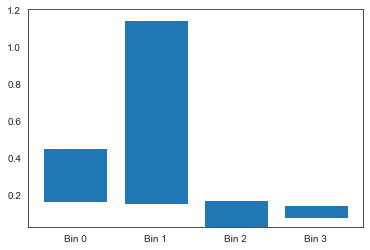

24
-0.002677309290776919 19
0.0 19
0.0 19
0.010178582593527274 20
0.004081887054855446 20
0.0 19
0.005493049502175856 20
0.0 19
0.010907359219288343 20
0.0 19
-0.0011020326839885075 19
0.0037960727398672067 20
0.0 19
0.0 19
0.009225557264720075 20
0.0022823593705280643 20
0.0 19
0.00341560549503489 20
-0.003872710597153689 19
0.0 19
0.00305888576720309 20
0.0044688577728339285 20
0.003925610856270245 20
0.0037907294237027878 20
0.008756434245429478 20
0.0024051507730971644 20
0.0030128135543349144 20
0.0 19
0.0020764066143491577 20
0.004273390996934717 20
-0.001774302002932604 19
0.0034304033352846597 20
0.003678332477403984 20
0.0 19
0.0026493036374274637 20
0.0 19
-0.1023930398152085 17
0.002463581910343321 20
0.0 19
0.0 19
-0.10361774567070815 17
-0.004537252619134846 19
0.0037950032970384406 20
0.00947431079349309 20
0.004309138638749044 20
0.0 19
0.002042632094836433 20
0.005040230173378513 20
0.003468914217951702 20
0.0 19
0.0025513188754068827 20
0.0013415415413369353 20
0.0 19


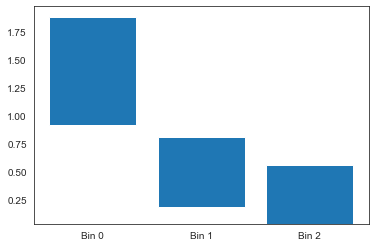

25
-0.0018756009021999864 19
0.0 19
-0.0035648151465643707 19
0.0017790734192624502 20
0.0021630859160864935 20
-0.0010161168602910164 19
0.0037348112279388945 20
-0.0012247506034136213 19
0.003243808513507418 20
0.0 19
-0.001953569206069733 19
0.0 19
0.0 19
0.0 19
0.00415941505936146 20
0.002173329863256468 20
0.0 19
0.00277864310234327 20
-0.003301753813217373 19
0.0 19
0.002326872724909279 20
0.001681146486853663 20
0.0010156123370344827 20
0.0 19
0.0019784748854699673 20
0.0 19
0.00345790462287493 20
0.0 19
0.0014303289760428939 20
0.003330579323908872 20
0.0 19
0.0020366232818912477 20
0.001904955991653301 20
0.0 19
0.001712379702940442 20
0.0 19
-0.007104530852317334 19
0.0031593362087843357 20
-0.0016390917823790319 19
0.0 19
-0.004434050207973623 19
-0.0021511808707203872 19
0.001163671133636135 20
0.002803427431168487 20
0.001193275291129725 20
-0.0033463324150304063 19
0.0 19
0.0012312931878882272 20
0.0021042935719198796 20
0.0 19
0.0 19
0.006701376303857674 20
0.0 19
0.0 19

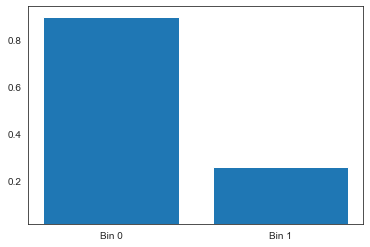

26
-0.019322801982461113 19
-0.029597004980849134 19
-0.02658976491984011 19
0.03086150931989451 20
0.03769659590771052 20
-0.02927613931345302 19
0.036935223851671806 20
-0.02742624460751647 19
0.03606727714392435 20
-0.02874837589051671 19
-0.026523649629879326 19
0.0329810344313578 20
0.025992981255683778 20
-0.021568344451839333 19
0.03850175031609199 20
0.0 19
-0.02877147536773972 19
0.03760332369656552 20
-0.026247164378132876 19
-0.02148689644481888 19
0.03905036834023895 20
0.03848072186231544 20
0.03867581761517508 20
0.034463708702757584 20
0.06689154354019497 21
0.037847107994585905 20
0.0334419230074216 20
-0.0241710571556758 19
0.03491584906986672 20
0.032762050293125455 20
-0.0270391937606502 19
0.03635101741576502 20
0.03523766250771379 20
-0.027369329899807948 19
0.0 19
-0.024808869509018006 19
-0.007101937982538811 19
0.03897442080710717 20
-0.02720782391339807 19
0.05011309769490506 21
-0.007011236485630947 19
-0.027752548679938982 19
0.030799709741177433 20
0.0234822

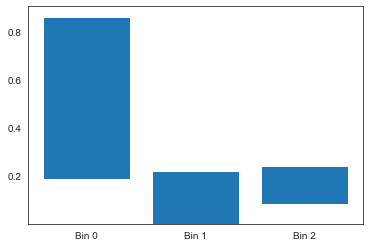

27
-0.050193760436786194 18
-0.031162007697100896 19
-0.035947511061480475 19
0.030255097100280653 20
0.025442726149322373 20
-0.028856720762330534 19
0.033816359160301956 20
-0.026508207087788394 19
0.032189299899123974 20
-0.029953411161271704 19
-0.03264130508330787 19
0.03232669202928229 20
0.013946530806054513 20
0.022773486013188876 20
0.03154847229841323 20
0.007164645389276775 20
-0.02783897577899863 19
0.03761409332633203 20
-0.034643395464891424 19
-0.04905287365356986 19
0.039304367298326426 20
0.03344001368877536 20
0.034885134679601526 20
0.0346243806080721 20
0.030305033065871297 20
0.034058167170431475 20
0.03184797464720929 20
-0.023230683542709074 19
0.025009371271697084 20
0.03195953591441572 20
-0.027738502675890397 19
0.03250646021236464 20
0.03153898499122171 20
-0.029691100925291092 19
0.005884738634699155 20
-0.014235303794293108 19
-0.04432876861036185 19
0.03432099004215902 20
-0.02928357018205152 19
-0.04522753271309725 19
-0.0426708108537878 19
-0.03016806090

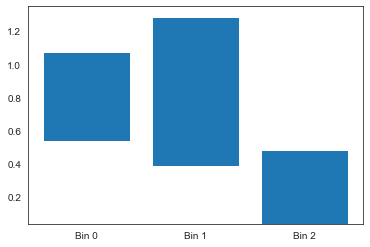

28
0.0 19
-0.0029856358306610264 19
-0.004855624467351827 19
0.0014863116332236581 20
0.0029905930821031435 20
-0.002056886855265838 19
0.002554125456761036 20
0.0 19
0.0009880836164951612 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0014807688808450847 20
0.0014022507797447625 20
0.0 19
0.0 19
0.0 19
0.0 19
0.003209046603961485 20
0.0 19
0.0008069191894244931 20
0.0030334426890776256 20
-0.027678660519169347 19
0.0013935159158646182 20
0.0019094274604293804 20
0.0 19
0.0044984838922266235 20
0.0 19
0.0 19
0.00184182700178126 20
0.001877550997335553 20
0.0 19
0.0014515698748179817 20
0.0 19
-0.011725403721290308 19
-0.062210592659994526 18
0.0 19
0.0 19
-0.0071101711194671135 19
0.0 19
0.0017679471032626126 20
0.0013023817585854636 20
0.002450994881048829 20
0.0 19
0.0025412701160426043 20
0.0018084602904508973 20
0.0022956078008725678 20
0.0 19
0.002402531083634585 20
0.0 19
0.0 19
0.0 19
-0.08759158474261915 18
-0.007824860438372161 19
0.002896822938889154 20
0.0 19
0.0024266852957193774 

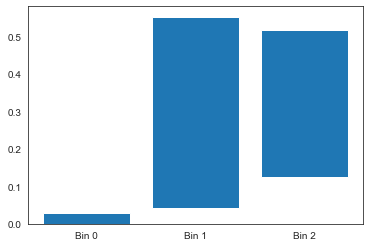

29
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0015132894253917506 20
0.0 19
0.0 19
0.0008284939167284011 20
0.0 19
0.0 19
0.0018734277794236753 20
0.0 19
0.0 19
0.0 19
-0.001229130425784597 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.003062484321824377 20
0.0 19
0.0 19
0.0 19
0.0024102992731898087 20
0.0 19
0.0 19
0.0009971558302974137 20
0.0 19
0.001517549161696774 20
0.0 19
-0.013259452972530936 19
0.0009195150825006548 20
0.0 19
0.0 19
-0.012594554754088045 19
0.0 19
0.0007005560382464249 20
0.0014185103498081109 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0010738185621798624 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0015850650932505705 20
0.0 19
0.0 19
0.0 19
0.0 19


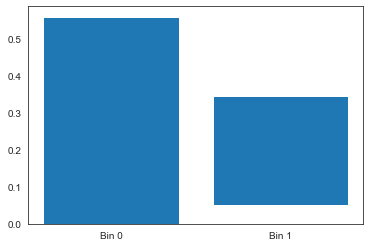

In [34]:
shap_distribs = []
sns.set_style("white")
for i in range(len(feat_list)):
    print (i)
    shap_vals = shap_val_feat[i]
    
    #zscore = scp.stats.zscore(shap_vals)
    
    #print(len(shap_vals))
    #print(each)
    #rel_shap_vals = []
    #for n in range(len(zscore)):
    #    if type(zscore[n]) != float or (zscore[n] < 3 and zscore[n] > -3):
    #        rel_shap_vals.append(shap_vals[n])
    #print(len(rel_shap_vals))

    #shap_min = math.floor(min(rel_shap_vals)*100)/100.0
    #shap_max = math.ceil(max(rel_shap_vals)*100)/100.0
    #print(min(shap_vals), max(shap_vals))
    #print(shap_min, shap_max)
    #bins = np.linspace(shap_min, shap_max+0.01, 20)
    
    bins = np.arange(-1, 1, 0.05)
    
    feat_vals = []
    for sbin in range(len(bins)):
        nl = []
        feat_vals.append(nl)
    
    for j in range(len(shap_vals)):
        val = shap_vals[j]
        b = 0
        cur_bin = bins[b]
        idx = b

        while val > cur_bin:
            #print(cur_bin)
            idx = b
            b+=1
            cur_bin = bins[b]

        print(val, idx)
        feat_vals[idx].append(feats[i][j])
        
    for each in feat_vals:
        zscore = scp.stats.zscore(each)
        #print(each)
        for n in range(len(zscore)):
            if zscore[n] > 3 or zscore[n] < -3:
                np.delete(zscore, n)
                del each[n]
        #print(each)
    #append min and max to dictionary
    mins = []
    maxes = []
    width = []
    #print(feat_vals)
    n = 0
    for each in feat_vals:
        if each != []:
            mins.append(min(each))
            maxes.append(max(each))
            width.append("Bin "+str(n))
            n+=1
    plt.bar(width, maxes, bottom = mins)
    plt.show()
    
    feat_name = feat_list[i]
    
    feat_dict = {'Feature Name': feat_name}
    for each in feat_vals:
        if each != []:
            mins.append(min(each))
            maxes.append(max(each))
        else:
            mins.append(None)
            maxes.append(None)
            
    feat_dict['bins'] = bins
    feat_dict['mins'] = mins
    feat_dict['maxes'] = maxes
    #i = 1
    #for n in range(len(feat_vals)-1):
     #   bin_name = "Bin" + str(i)
      #  i+=1
        
       # shap_range = (bins[n], bins[n+1])
        #if feat_vals[n] != []:
         #   feat_range = (min(feat_vals[n]), max(feat_vals[n]))
        #else:
         #   feat_range = None
        
        #feat_dict[bin_name+"_shap_vals"] = shap_range
        #feat_dict[bin_name+"_feat_vals"] = feat_range
    shap_distribs.append(feat_dict)

In [35]:
def create_samples(shap_explainer, iterations, row, features, top = 10):
    length = len(features)
    
    exp = []
    rel_exp = []
    
    for j in range(iterations):
        #print(X_test_frame.loc[row])
        shap_values = shap_explainer.shap_values(row)
        #print(shap_values)

        importances = []
        
        if type(shap_explainer) == shap.explainers.kernel.KernelExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][0][i]
                abs_val = abs(shap_values[0][0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
        else:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][i]
                abs_val = abs(shap_values[0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
                #print(entry)

        importances.sort(key=lambda tup: tup[2], reverse = True)
        
        exp.append(importances)

        rel_feat = []

        for i in range(top):
            feat = importances[i]
            if feat[2] > 0:
                rel_feat.append(feat)
                
        rel_exp.append(rel_feat)
        
    return exp, rel_exp

In [36]:
#shap_stability_scores = []
probas = []
shap_changes = []

for instance in results:
    
    print("INDEX = %d" %instance['index'])
    patients_feat = pd.Series(instance['scaled_vector'])
    prediction = instance['predictions']
    p1 = instance['prediction_probability'][1]
    probas.append(instance['prediction_probability'][1])
    
    loc = results.index(instance)
    
    exp, rel_exp = create_samples(shap_explainer, 3, patients_feat.values.reshape(-1, 30), feature_names, top = MAX_FEAT)
    
    features = []
    shap_vals = []

    for explanation in rel_exp:
        features.extend([feat[0] for feat in explanation])
        shap_vals.extend([feat for feat in explanation])
        
    #arr = [np.array(x) for x in shap_vals]
    #mean_vals = [np.mean(k) for k in zip(*arr)]
    #print(shap_vals, mean_vals)
    
    counter = Counter(features).most_common(MAX_FEAT)

    feats = [feat[0] for feat in counter]
    
    rel_feats = []
    
    #print(shap_vals)
    
    for feat in feats:
        vals = [i[1] for i in shap_vals if i[0] == feat]
        #print(feat, vals)
        val = np.mean(vals)
        rel_feats.append((feat, val))
    
    intervals = []
    for item in rel_feats:
        feat = item [0]
        val = item[1]
        print("Creating distribution for feature", rel_feats.index(item))
        
        #print(item)
        #print(feat)
        n = feat_list.index(feat)
        feat_dict = shap_distribs[n]
        
        if feat_dict['Feature Name'] != feat:
            for each in distribs:
                if feat_dict['Feature Name'] == feat:
                    feat_dict = each
        
        bins = feat_dict['bins']
        mins = feat_dict['mins']
        maxes = feat_dict['maxes']
        #print (feat, val, bins, mins, maxes)
        
        i = 0
        while val > bins[i]:
            idx = i
            i+=1
        #print (i)
        if mins[i] != None:
            min_val = mins[i]
            max_val = maxes[i]
        else:
            j = i
            while mins[j] == None and j > 0:
                min_val = mins[j-1]
                max_val = maxes[j-1]
                j = j-1
                
        interval = max_val - min_val
        
        index = feat_list.index(feat)
        int_min = max_val
        int_max = max_val + interval
        intervals.append((feature_name, index, int_min, int_max))

    diffs = []
    for iteration in range(3):
        print("Pertubing - Run", iteration+1)
        alt_x = np.copy(patients_feat)
        #print("original:", alt_x)
        for each in intervals:
            new_val = random.uniform(each[2], each[3])
         #   print(each[1])
         #   print(new_val)
            alt_x[each[1]] = new_val
        #print("altered:", alt_x)
        p2 = model.predict_proba(alt_x.reshape(-1, len(alt_x)))[0][0]
        diff = p1-p2
        diffs.append(diff)
    
    shap_changes.append(np.mean(diffs))


INDEX = 37



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 0



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 13



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 36



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 61



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 20



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 1



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 28



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 50



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 54



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 56



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 39



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 2



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 3



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 6



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 8



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 10



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 11



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 17



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 19



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 31



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 34



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 42



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 46



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 53



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 63



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3


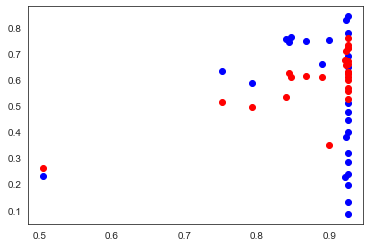

In [37]:
plt.plot(probas, changes, 'bo', label = 'LIME')
plt.plot(probas, shap_changes, 'ro', label = 'SHAP')
plt.show()

In [38]:
#RMSE
sq_changes = []
abs_changes = []
for each in shap_changes:
    sq_changes.append(each**2)
    abs_changes.append(abs(each))
MSE = sum(sq_changes)/len(sq_changes)
RMSE = math.sqrt(MSE)
MAE = sum(abs_changes)/len(abs_changes)

print('MSE:', MSE)
print('RMSE:', RMSE)
print('MAE:', MAE)

percent_change = []

for i in range(len(probas)):
    #change = probas[i] - shap_changes[i]
    rel_change = changes[i]/probas[i]
    percent_change.append(abs(rel_change))
MAPE = sum(percent_change)/len(percent_change)
print('MAPE:', MAPE)

MSE: 0.376479811908766
RMSE: 0.6135795074061438
MAE: 0.6036451252607199
MAPE: 0.5884210192240201


In [39]:
tree_explainer = shap.TreeExplainer(model)#, data_sample)
shap_values = tree_explainer.shap_values(X_test_frame)
shap_val_feat = np.transpose(shap_values)
feats = np.transpose(X_test_frame.values)

0


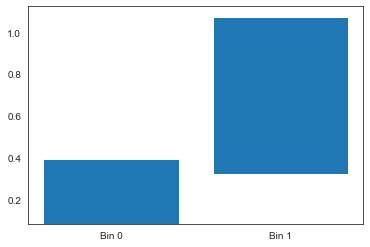

1


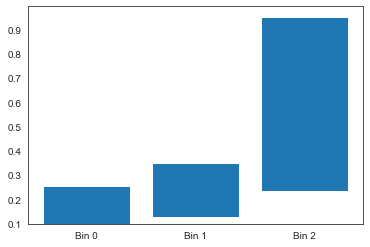

2


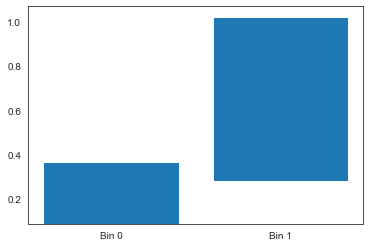

3


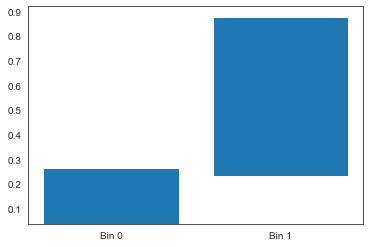

4


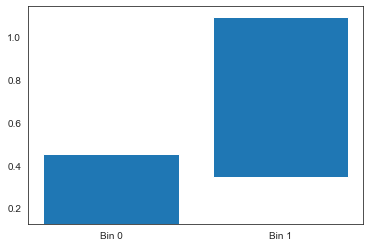

5


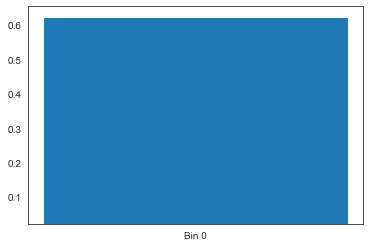

6


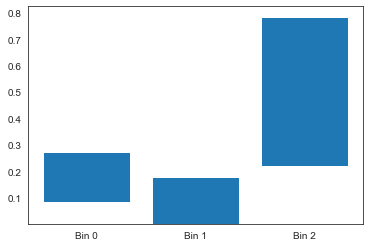

7


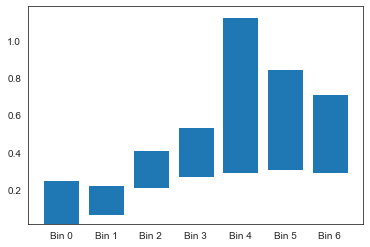

8


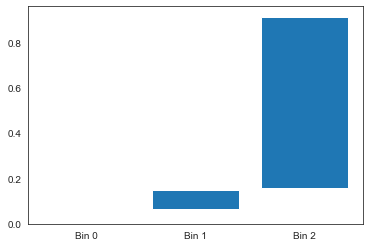

9


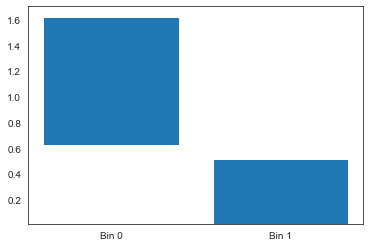

10


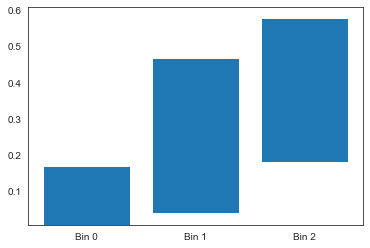

11


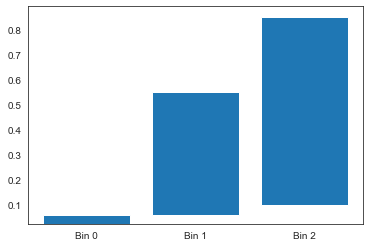

12


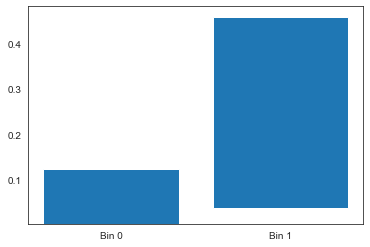

13


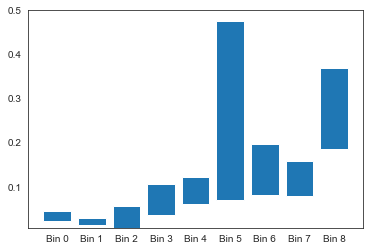

14


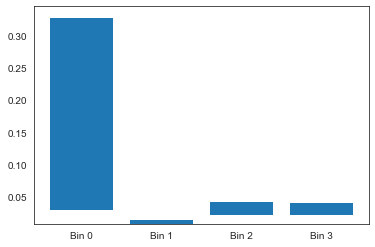

15


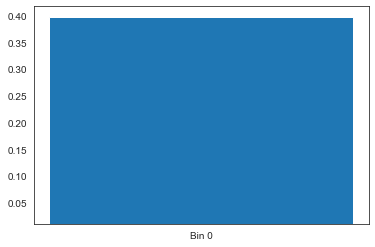

16


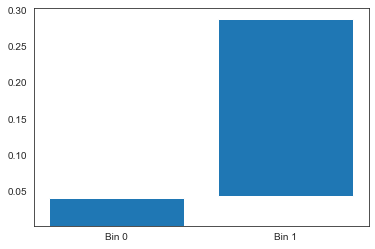

17


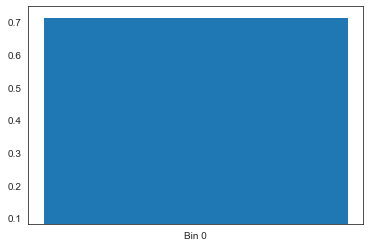

18


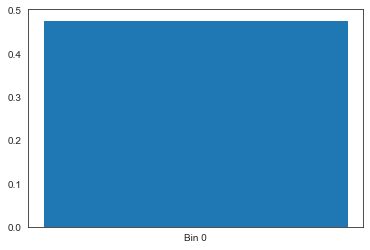

19


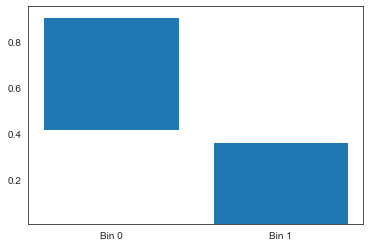

20


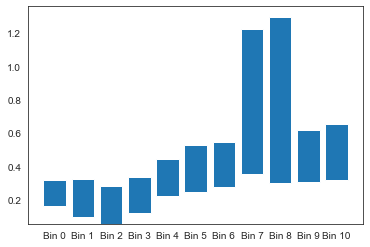

21


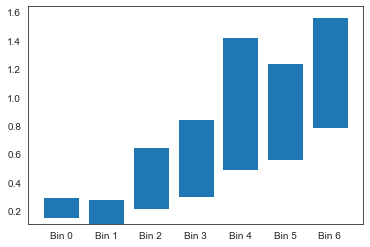

22


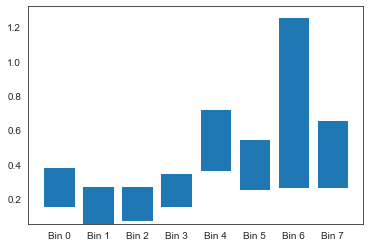

23


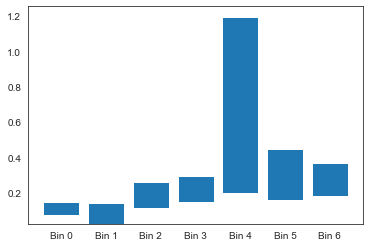

24


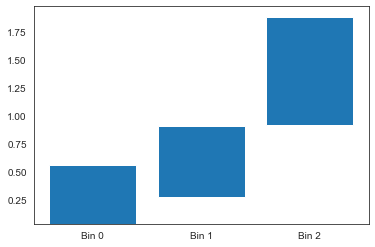

25


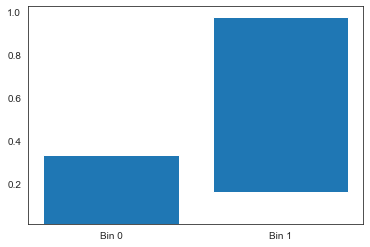

26


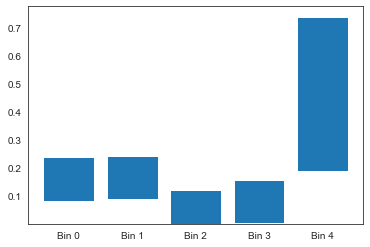

27


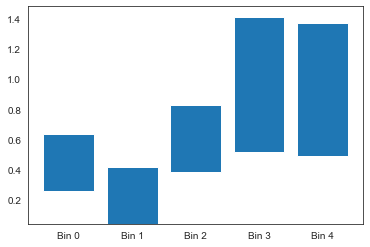

28


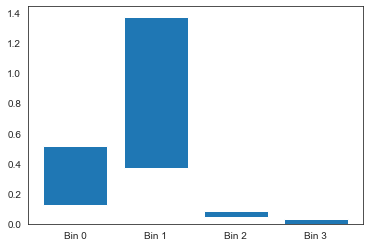

29


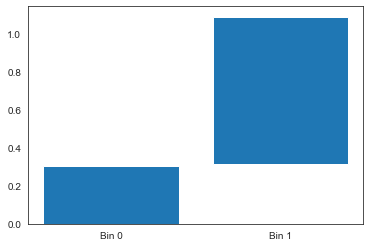

In [40]:
tree_distribs = []
sns.set_style("white")
for i in range(len(feat_list)):
    print (i)
    shap_vals = shap_val_feat[i]
    
    #zscore = scp.stats.zscore(shap_vals)
    
    #print(len(shap_vals))
    #print(each)
    #rel_shap_vals = []
    #for n in range(len(zscore)):
    #    if type(zscore[n]) != float or (zscore[n] < 3 and zscore[n] > -3):
    #        rel_shap_vals.append(shap_vals[n])
    #print(len(rel_shap_vals))

    #shap_min = math.floor(min(rel_shap_vals)*100)/100.0
    #shap_max = math.ceil(max(rel_shap_vals)*100)/100.0
    #print(min(shap_vals), max(shap_vals))
    #print(shap_min, shap_max)
    #bins = np.linspace(shap_min, shap_max+0.01, 20)
    
    bins = np.arange(-1, 1, 0.1)
    
    feat_vals = []
    for sbin in range(len(bins)):
        nl = []
        feat_vals.append(nl)
    
    for j in range(len(shap_vals)):
        val = shap_vals[j]
        b = 0
        cur_bin = bins[b]
        idx = b

        while val > cur_bin:
            #print(cur_bin)
            idx = b
            b+=1
            cur_bin = bins[b]

        #print(val, idx)
        feat_vals[idx].append(feats[i][j])
        
    for each in feat_vals:
        zscore = scp.stats.zscore(each)
        #print(each)
        for n in range(len(zscore)):
            if zscore[n] > 3 or zscore[n] < -3:
                np.delete(zscore, n)
                del each[n]
        #print(each)
    #append min and max to dictionary
    mins = []
    maxes = []
    width = []
    #print(feat_vals)
    n = 0
    for each in feat_vals:
        if each != []:
            mins.append(min(each))
            maxes.append(max(each))
            width.append("Bin "+str(n))
            n+=1
    plt.bar(width, maxes, bottom = mins)
    plt.show()
    
    feat_name = feat_list[i]
    
    feat_dict = {'Feature Name': feat_name}
    for each in feat_vals:
        if each != []:
            mins.append(min(each))
            maxes.append(max(each))
        else:
            mins.append(None)
            maxes.append(None)
            
    feat_dict['bins'] = bins
    feat_dict['mins'] = mins
    feat_dict['maxes'] = maxes
    #i = 1
    #for n in range(len(feat_vals)-1):
     #   bin_name = "Bin" + str(i)
      #  i+=1
        
       # shap_range = (bins[n], bins[n+1])
        #if feat_vals[n] != []:
         #   feat_range = (min(feat_vals[n]), max(feat_vals[n]))
        #else:
         #   feat_range = None
        
        #feat_dict[bin_name+"_shap_vals"] = shap_range
        #feat_dict[bin_name+"_feat_vals"] = feat_range
    tree_distribs.append(feat_dict)

In [41]:
tree_changes = []
probas = []
feat_list = list(feature_names)

for instance in results:
    
    print("INDEX = %d" %instance['index'])
    patients_feat = pd.Series(instance['scaled_vector'])
    prediction = instance['predictions']
    p1 = instance['prediction_probability'][1]
    probas.append(instance['prediction_probability'][1])
    
    loc = results.index(instance)
    
    exp, rel_exp = create_samples(tree_explainer, 3, patients_feat.values.reshape(-1, 30), feature_names, top = MAX_FEAT)
    
    features = []
    shap_vals = []

    for explanation in rel_exp:
        features.extend([feat[0] for feat in explanation])
        shap_vals.extend([feat for feat in explanation])
        
    #arr = [np.array(x) for x in shap_vals]
    #mean_vals = [np.mean(k) for k in zip(*arr)]
    #print(shap_vals, mean_vals)
    
    counter = Counter(features).most_common(MAX_FEAT)

    feats = [feat[0] for feat in counter]
    
    rel_feats = []
    
    #print(shap_vals)
    
    for feat in feats:
        vals = [i[1] for i in shap_vals if i[0] == feat]
        #print(feat, vals)
        val = np.mean(vals)
        rel_feats.append((feat, val))
    
    intervals = []
    for item in rel_feats:
        feat = item [0]
        val = item[1]
        print("Creating distribution for feature", rel_feats.index(item))
        
        #print(item)
        #print(feat)
        n = feat_list.index(feat)
        feat_dict = tree_distribs[n]
        
        if feat_dict['Feature Name'] != feat:
            for each in distribs:
                if feat_dict['Feature Name'] == feat:
                    feat_dict = each
        
        bins = feat_dict['bins']
        mins = feat_dict['mins']
        maxes = feat_dict['maxes']
        #print (feat, val, bins, mins, maxes)
        
        i = 0
        while val > bins[i]:
            idx = i
            i+=1
        #print (i)
        if mins[i] != None:
            min_val = mins[i]
            max_val = maxes[i]
        else:
            j = i
            while mins[j] == None and j > 0:
                min_val = mins[j-1]
                max_val = maxes[j-1]
                j = j-1
                
        interval = max_val - min_val
        
        index = feat_list.index(feat)
        int_min = max_val
        int_max = max_val + interval
        intervals.append((feature_name, index, int_min, int_max))

    diffs = []
    for iteration in range(3):
        print("Pertubing - Run", iteration+1)
        alt_x = np.copy(patients_feat)
        #print("original:", alt_x)
        for each in intervals:
            new_val = random.uniform(each[2], each[3])
         #   print(each[1])
         #   print(new_val)
            alt_x[each[1]] = new_val
        #print("altered:", alt_x)
        p2 = model.predict_proba(alt_x.reshape(-1, len(alt_x)))[0][0]
        diff = p1-p2
        diffs.append(diff)
    
    tree_changes.append(np.mean(diffs))

INDEX = 37
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 0
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 13
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for featur

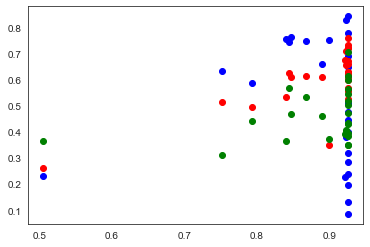

In [42]:
plt.plot(probas, changes, 'bo', label = 'LIME')
plt.plot(probas, shap_changes, 'ro', label = 'SHAP')
plt.plot(probas, tree_changes, 'go', label = 'SHAP')
plt.show()

In [43]:
#RMSE
sq_changes = []
abs_changes = []
for each in tree_changes:
    sq_changes.append(each**2)
    abs_changes.append(abs(each))
MSE = sum(sq_changes)/len(sq_changes)
RMSE = math.sqrt(MSE)
MAE = sum(abs_changes)/len(abs_changes)

print('MSE:', MSE)
print('RMSE:', RMSE)
print('MAE:', MAE)

percent_change = []

for i in range(len(probas)):
    #change = probas[i] - tree_changes[i]
    rel_change = changes[i]/probas[i]
    percent_change.append(abs(rel_change))
MAPE = sum(percent_change)/len(percent_change)
print('MAPE:', MAPE)

MSE: 0.22117907364429665
RMSE: 0.47029679314694106
MAE: 0.4603683833892529
MAPE: 0.5884210192240201


In [44]:
mean_changes = []
rank_corrs = []
IDS = np.arange(1, len(results)+1, 1)
for instance in results:
    patients_feat = pd.Series(instance['scaled_vector'])
    shap_exp, rel_exp = create_samples(shap_explainer, 1, patients_feat.values.reshape(-1, 30), feature_names, top = MAX_FEAT)
    tree_exp, rel_exp = create_samples(shap_explainer, 1, patients_feat.values.reshape(-1, 30), feature_names, top = MAX_FEAT)

    shap_weights = [0]*len(features)
    tree_weights = [0]*len(features)

    for each in features:
        list_idx = feat_list.index(each)
        #print ("Feature", list_idx)
        for explanation in shap_exp[0]:
            #print(explanation)
            if each in explanation[0]:
                shap_weights[list_idx] = explanation[1]
        for explanation in tree_exp[0]:
            if each in explanation[0]:
                tree_weights[list_idx] = explanation[1]

    weight_diff = [abs(shap_weights[i]-tree_weights[i]) for i in range(len(shap_weights))]
    mean_change = np.mean(weight_diff)
    print ('Mean change in shap values:', mean_change)

    shap_ranking = scp.stats.rankdata(shap_weights)
    tree_ranking = scp.stats.rankdata(tree_weights)
    corr, p_val = scp.stats.spearmanr(shap_weights, tree_weights)
    print('Rank Correlation:', corr)
    
    mean_changes.append(mean_change)
    rank_corrs.append(corr)


Mean change in shap values: 0.00017402440993549454
Rank Correlation: 1.0



Mean change in shap values: 0.0001100393222829917
Rank Correlation: 1.0



Mean change in shap values: 0.0007063252671283493
Rank Correlation: 0.9277195196334961



Mean change in shap values: 0.0002354922880204502
Rank Correlation: 1.0



Mean change in shap values: 0.00014445790010058634
Rank Correlation: 1.0



Mean change in shap values: 0.0001991218222695971
Rank Correlation: 0.9524294617392094



Mean change in shap values: 0.00015158894127726834
Rank Correlation: 0.9979695431472081



Mean change in shap values: 0.00021363368431417395
Rank Correlation: 0.9524294617392094



Mean change in shap values: 0.0009019845651895101
Rank Correlation: 0.9601184360106375



Mean change in shap values: 0.0003297710063675944
Rank Correlation: 0.9993680884676146



Mean change in shap values: 0.0002886181686723499
Rank Correlation: 1.0



Mean change in shap values: 0.00029664381923415103
Rank Correlation: 1.0



Mean change in shap values: 0.00036420549050189636
Rank Correlation: 0.9993231810490694



Mean change in shap values: 0.0005700989855021145
Rank Correlation: 1.0



Mean change in shap values: 0.00031574173148122365
Rank Correlation: 0.9993680884676146



Mean change in shap values: 0.00031766042089666766
Rank Correlation: 1.0



Mean change in shap values: 0.0003991867749410965
Rank Correlation: 0.9662552918869455



Mean change in shap values: 0.00023834733711117494
Rank Correlation: 0.9993231810490694



Mean change in shap values: 0.0004403180094257405
Rank Correlation: 0.9993680884676146



Mean change in shap values: 0.0002493094834319217
Rank Correlation: 1.0



Mean change in shap values: 0.00024844269092156126
Rank Correlation: 0.9993680884676146



Mean change in shap values: 0.00036122817232858245
Rank Correlation: 0.9979695431472081



Mean change in shap values: 0.0002324770037867907
Rank Correlation: 1.0



Mean change in shap values: 0.00018060131192742339
Rank Correlation: 1.0



Mean change in shap values: 0.00026934299503079316
Rank Correlation: 0.9662552918869455



Mean change in shap values: 0.0002650806715986951
Rank Correlation: 0.9993680884676146


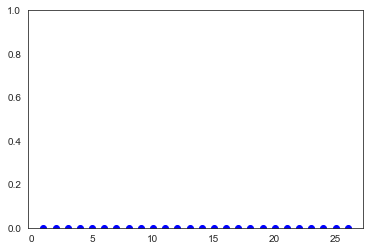

In [45]:
plt.plot(IDS, mean_changes, 'bo')
plt.ylim(0, 1)
plt.show()

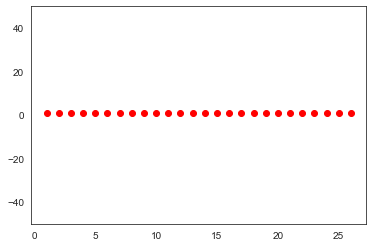

In [46]:
plt.plot(IDS, rank_corrs, 'ro')
plt.ylim(-50,50)
plt.show()

In [47]:
for i in range(len(shap_distribs)):
    print("Kernel:\n", len(shap_distribs[i]['bins']), len(shap_distribs[i]['mins']), len(shap_distribs[i]['maxes']))
    print("Tree:\n", len(tree_distribs[i]['bins']), len(tree_distribs[i]['mins']), len(tree_distribs[i]['maxes']))

Kernel:
 40 42 42
Tree:
 20 22 22
Kernel:
 40 42 42
Tree:
 20 23 23
Kernel:
 40 42 42
Tree:
 20 22 22
Kernel:
 40 42 42
Tree:
 20 22 22
Kernel:
 40 42 42
Tree:
 20 22 22
Kernel:
 40 42 42
Tree:
 20 21 21
Kernel:
 40 42 42
Tree:
 20 23 23
Kernel:
 40 44 44
Tree:
 20 27 27
Kernel:
 40 42 42
Tree:
 20 23 23
Kernel:
 40 42 42
Tree:
 20 22 22
Kernel:
 40 42 42
Tree:
 20 23 23
Kernel:
 40 42 42
Tree:
 20 23 23
Kernel:
 40 42 42
Tree:
 20 22 22
Kernel:
 40 44 44
Tree:
 20 29 29
Kernel:
 40 42 42
Tree:
 20 24 24
Kernel:
 40 42 42
Tree:
 20 21 21
Kernel:
 40 42 42
Tree:
 20 22 22
Kernel:
 40 42 42
Tree:
 20 21 21
Kernel:
 40 42 42
Tree:
 20 21 21
Kernel:
 40 42 42
Tree:
 20 22 22
Kernel:
 40 46 46
Tree:
 20 31 31
Kernel:
 40 43 43
Tree:
 20 27 27
Kernel:
 40 44 44
Tree:
 20 28 28
Kernel:
 40 44 44
Tree:
 20 27 27
Kernel:
 40 43 43
Tree:
 20 23 23
Kernel:
 40 42 42
Tree:
 20 22 22
Kernel:
 40 43 43
Tree:
 20 25 25
Kernel:
 40 43 43
Tree:
 20 25 25
Kernel:
 40 43 43
Tree:
 20 24 24
Kernel:
 40 42

In [48]:
for i in range(len(shap_distribs)):
    print("Kernel:\n", shap_distribs[i]['mins'])
    print("Tree:\n", tree_distribs[i]['mins'])

Kernel:
 [0.16314496314496313, 0.08378378378378382, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 0.16314496314496313, 0.08378378378378382, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
Tree:
 [0.08378378378378382, 0.32088452088452085, None, None, None, None, None, None, None, None, None, 0.08378378378378382, 0.32088452088452085, None, None, None, None, None, None, None, None, None]
Kernel:
 [0.23564013840830456, 0.09861591695501731, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 0.23564013840830456, 0.09861591695501731, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
Tree:
 [0.09861591695501731, 0.12595155709342562, 0.23564013840830456, None, None, None, None, None, None, None, None, 0.09861591695501731, 0.12595155709342